In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

In [4]:
# Reading data from source
df = pd.read_csv(r'/home/aryan/playground/Duplicate Question Detection/data/questions.csv')

In [5]:
# Columns in the dataset
df.columns

Index(['id"', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [6]:
df.head(5)

,"id""",qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
# Shape of the data
df.shape

(404351, 6)

In [8]:
# Checking for null values
df.isna().sum()

id"             0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [9]:
# Dropping null values because its just 3 null values so dropping them is safe
df.dropna(inplace=True)

In [10]:
# Checking for null values
df.duplicated().sum()

np.int64(0)

In [11]:
# Dropping irrelevant columns
df.drop(['id"', 'qid1', 'qid2'], axis=1, inplace=True)

In [12]:
df.head(5)

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Text Preprocessing

In [13]:
import contractions
import unicodedata
import nltk
import string
import re
import emoji

In [14]:
# Lower casing the text
df['question1_preprocessed'] = df['question1'].str.lower()
df['question2_preprocessed'] = df['question2'].str.lower()

In [15]:
# Removing http links from the text
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# Apply the function to each text entry
df['question1_preprocessed'] = df['question1_preprocessed'].apply(remove_urls)
df['question2_preprocessed'] = df['question2_preprocessed'].apply(remove_urls)

During the exploratory analysis of our dataset, we observed that very less around 0.05% text entries contain URLs (e.g., https://t.co/...). These links are very important in differentiating question1 from question2 but since they are almost close to negligible so we are removing it.

In [16]:
# Expanding Contractions
df['question1_preprocessed'] = df['question1_preprocessed'].apply(lambda x: contractions.fix(x))
df['question2_preprocessed'] = df['question2_preprocessed'].apply(lambda x: contractions.fix(x))

In [17]:
# Removing Accents/Diacritics
def remove_accents_diacritics(text):
    """
    Normalize unicode text and remove accents/diacritics.
    Example: 'café' → 'cafe'
    """
    # Normalize to 'NFKD' form (decomposes accents)
    text = unicodedata.normalize('NFKD', text)
    # Keep only base characters (ignore diacritics)
    text = ''.join([c for c in text if not unicodedata.combining(c)])
    return text

df['question1_preprocessed'] = df['question1_preprocessed'].apply(remove_accents_diacritics)
df['question2_preprocessed'] = df['question2_preprocessed'].apply(remove_accents_diacritics)

In [18]:
# Convert emojis to text descriptions
def convert_emojis(text):
    return emoji.demojize(text)

df['question1_preprocessed'] = df['question1_preprocessed'].apply(convert_emojis)
df['question2_preprocessed'] = df['question2_preprocessed'].apply(convert_emojis)

In [19]:
# Removing punctuations from the text
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df['question1_preprocessed'] = df['question1_preprocessed'].apply(remove_punctuation)
df['question2_preprocessed'] = df['question2_preprocessed'].apply(remove_punctuation)

In [20]:
# Converting Raw text into Tokens
from nltk.tokenize import word_tokenize
df['question1_preprocessed'] = df['question1_preprocessed'].apply(lambda x: word_tokenize(x))
df['question2_preprocessed'] = df['question2_preprocessed'].apply(lambda x: word_tokenize(x))

In [21]:
# Lemmetization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

df['question1_preprocessed'] = df['question1_preprocessed'].apply(lemmatize_words)
df['question2_preprocessed'] = df['question2_preprocessed'].apply(lemmatize_words)

In [22]:
df["question1_preprocessed"] = df["question1_preprocessed"].apply(lambda x: " ".join(x))
df["question2_preprocessed"] = df["question2_preprocessed"].apply(lambda x: " ".join(x))

In [23]:
from sklearn.model_selection import train_test_split
X = df[['question1_preprocessed', 'question2_preprocessed']]
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Text Representation

In [24]:
import gensim.downloader as api
print(api.info()['models'].keys())

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


In [25]:
glove_model = api.load('fasttext-wiki-news-subwords-300')

In [46]:
from keras.layers import TextVectorization, Embedding

vectorizer = TextVectorization(
    max_tokens = 35_000,
    output_mode='int',
    output_sequence_length=50
)

In [47]:
all_questions = df["question1_preprocessed"].tolist() + df["question2_preprocessed"].tolist()
all_questions = [str(q) for q in all_questions]

In [48]:
vectorizer.adapt(all_questions)

In [49]:
vectorizer.vocabulary_size()

35000

In [50]:
question1_txt = df['question1_preprocessed'].values
question2_txt = df['question2_preprocessed'].values

In [51]:
# Embedding dimension
embedding_dim = glove_model.vector_size

# Vocabulary from TextVectorization
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)

# Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

matched_words = 0
oov_words = 0

for idx, word in enumerate(vocab):
    if word in glove_model:
        embedding_matrix[idx] = glove_model[word]
        matched_words += 1
    else:
        embedding_matrix[idx] = np.random.normal(
            scale=0.6, size=(embedding_dim,)
        )
        oov_words += 1

# Coverage statistics
coverage_percentage = (matched_words / vocab_size) * 100

print("✅ Vocabulary size        :", vocab_size)
print("✅ Matched GloVe words    :", matched_words)
print("❌ OOV (not in model)     :", oov_words)
print(f"📊 GloVe coverage         : {coverage_percentage:.2f}%")

✅ Vocabulary size        : 35000
✅ Matched GloVe words    : 28159
❌ OOV (not in model)     : 6841
📊 GloVe coverage         : 80.45%


In [52]:
# These are the dense vectors of each word taken from pretrained glove model each word is represented with 100 dense vectors
embedding_matrix.shape

(35000, 300)

In [53]:
from keras.layers import Embedding
import keras

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
    mask_zero=False
)

# Using special siamese lstm model for text similarity

In [54]:
from keras.layers import (
    Input, 
    Bidirectional, 
    LSTM, 
    GlobalMaxPooling1D, 
    Dense, 
    Dropout, 
    Lambda, 
    BatchNormalization, 
    LayerNormalization, 
    GlobalAveragePooling1D, 
    Concatenate
)
from keras.models import Model
from keras.optimizers import Nadam


In [55]:
# RAW TEXT inputs
q1_input = Input(shape=(), dtype=tf.string)
q2_input = Input(shape=(), dtype=tf.string)

# Vectorizer INSIDE the model
q1_int = vectorizer(q1_input)
q2_int = vectorizer(q2_input)

# Shared encoder (embedding + LSTM + pooling)
max_len = 50
encoder_input = Input(shape=(max_len,), dtype='int32')

x = embedding_layer(encoder_input)
x = Bidirectional(LSTM(128, return_sequences=True, use_cudnn=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True, use_cudnn=True))(x)
max_pool = GlobalMaxPooling1D()(x)
avg_pool = GlobalAveragePooling1D()(x)

x = Concatenate()([max_pool, avg_pool])
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)

encoder = Model(encoder_input, x)

# Encode both questions
q1_vec = encoder(q1_int)
q2_vec = encoder(q2_int)

# Manhattan similarity
def manhattan_distance(vects):
    q1, q2 = vects
    return tf.exp(-tf.reduce_sum(tf.abs(q1 - q2), axis=1, keepdims=True))

similarity = Lambda(manhattan_distance)([q1_vec, q2_vec])

# Final model
siamese_model = Model([q1_input, q2_input], similarity)

siamese_model.compile(
    optimizer=Nadam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [56]:
siamese_model.summary(show_trainable=True, line_length=115)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape            ┃          Param # ┃ Connected to            ┃ Trainable ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)   │ (None)                  │                0 │ -                       │     -     │
├──────────────────────────────┼─────────────────────────┼──────────────────┼─────────────────────────┼───────────┤
│ input_layer_4 (InputLayer)   │ (None)                  │                0 │ -                       │     -     │
├──────────────────────────────┼─────────────────────────┼──────────────────┼─────────────────────────┼───────────┤
│ text_vectorization_1         │ (None, 50)              │                0 │ input_layer_3[0][0],    │     -     │
│ (TextVectorization)          │                         │                  │ input_layer_4[0][0]     │           │
├──────────────────────────────┼─────────────────────────┼──────────────────┼─────────────────────────┼───────────┤
│ functional_2 (Functional)    │ (None, 64)              │       11,144,800 │ text_vectorization_1[0… │     Y     │
│                              │                         │                  │ text_vectorization_1[1… │           │
├──────────────────────────────┼─────────────────────────┼──────────────────┼─────────────────────────┼───────────┤
│ lambda_1 (Lambda)            │ (None, 1)               │                0 │ functional_2[0][0],     │     -     │
│                              │                         │                  │ functional_2[1][0]      │           │
└──────────────────────────────┴─────────────────────────┴──────────────────┴─────────────────────────┴───────────┘

 Total params: 11,144,800 (42.51 MB)

 Trainable params: 11,144,800 (42.51 MB)

 Non-trainable params: 0 (0.00 B)

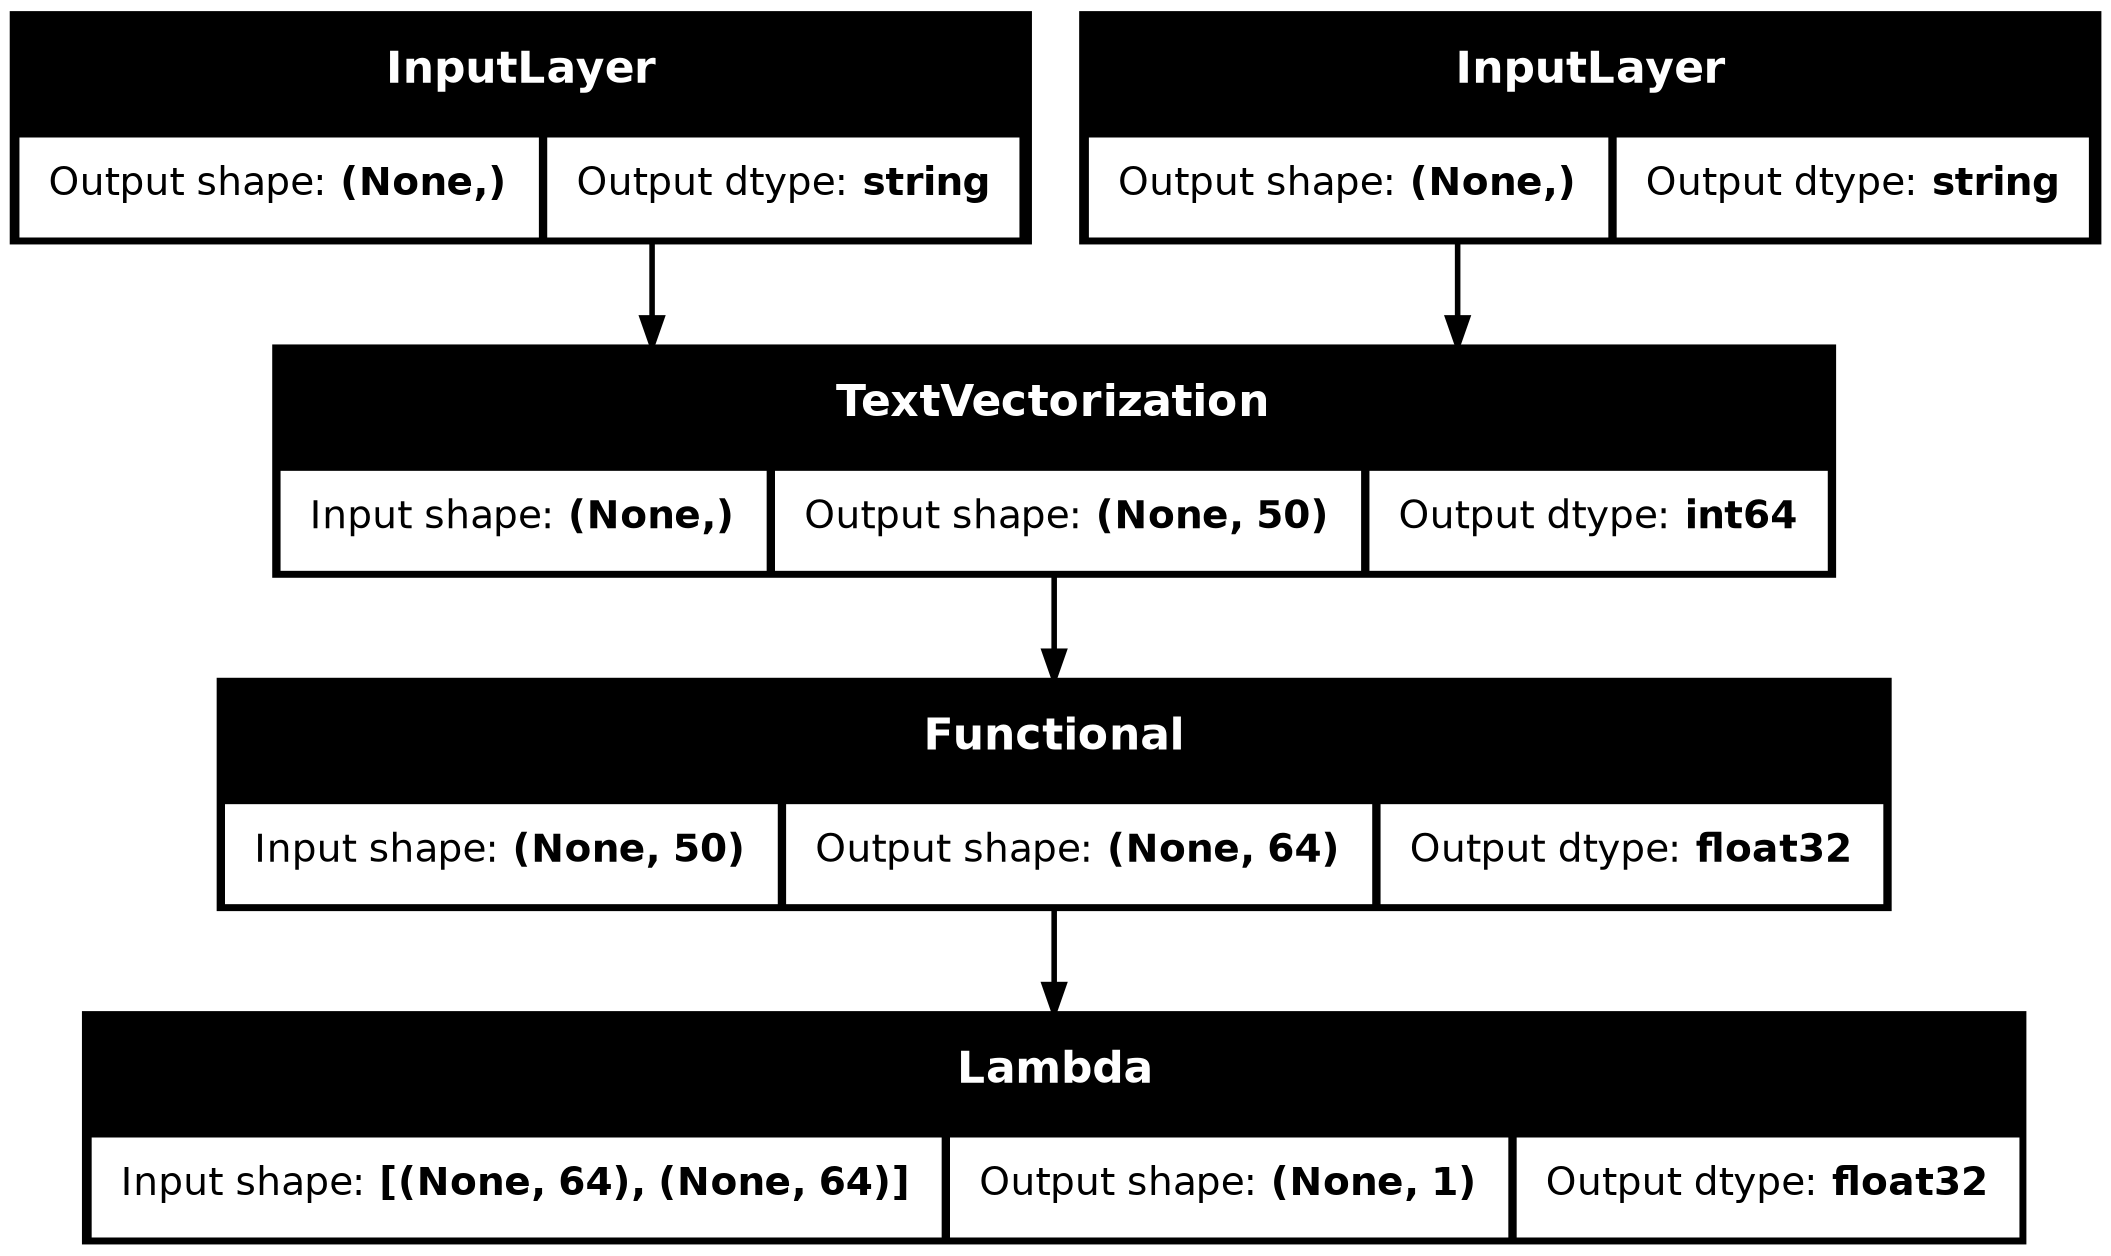

In [57]:
from keras.utils import plot_model
plot_model(siamese_model, show_dtype=True, show_shapes=True)

In [59]:
print(X_train.shape)
print(X_test.shape)

(323478, 2)
(80870, 2)


In [60]:
q1_train = df['question1_preprocessed'].values
q2_train = df['question2_preprocessed'].values
y_train  = df['is_duplicate'].values

siamese_model.fit(
    [q1_train, q2_train],
    y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2
)

Epoch 1/5
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 221s 86ms/step - accuracy: 0.7146 - loss: 0.5389 - val_accuracy: 0.7236 - val_loss: 0.5710
Epoch 2/5
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 218s 86ms/step - accuracy: 0.7813 - loss: 0.4595 - val_accuracy: 0.7519 - val_loss: 0.5394
Epoch 3/5
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 219s 87ms/step - accuracy: 0.7982 - loss: 0.4301 - val_accuracy: 0.7656 - val_loss: 0.5142
Epoch 4/5
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 221s 88ms/step - accuracy: 0.8130 - loss: 0.4075 - val_accuracy: 0.7859 - val_loss: 0.4821
Epoch 5/5
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 223s 88ms/step - accuracy: 0.8228 - loss: 0.3864 - val_accuracy: 0.7867 - val_loss: 0.4841
